<div style='width: 750px; margin-left: 30px;'><h3>A quick introduction, and playground for Multi-armed Bandit Problems/Algorithms</h3>
<br />
<div style='font-size:16px; font-family:Sans-Serif;'>

<h4>Base case</h4>
<ul style='margin-left:30px'>
<li>There is a set $\mathcal{A}$ of m actions (or arms) that is available to the agent.</li>
<li>Each action $a$ is associated with a reward distribution $\mathcal{R}^a$. </li>
<li>At each timestep $t$, the agent chooses an action $a_t \in \mathcal{A}$ and receives a reward $r_t \sim \mathcal{R}^{a_t}$.</li>
<li>The agent's goal is to maximize total reward: $ \sum_{t=1}^T r_t$.</li>
</ul> <br />
The last statement is equivalent to minimizing regret, where we define regret as the difference between the reward asscoaited with the best possible action at step $t$, and the reward that was actually received: $l_t=\max\limits_{a_t \in \mathcal{A}}\mathbf{E}[r_t|a_t]-r_t$
<p></p>
</div>
</div>

In [258]:
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

<h4>Four normals with different expected/variance.</h4> <br />
$
\begin{align}
\mathcal{R_1} &\sim \mathcal{N}(15, 10)\\
\mathcal{R_1} &\sim \mathcal{N}(5, 25)\\
\mathcal{R_1} &\sim \mathcal{N}(20, 25)\\
\mathcal{R_1} &\sim \mathcal{N}(30, 20)
\end{align}
$

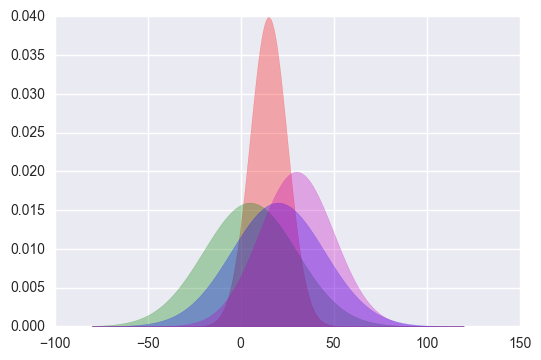

In [438]:
params = [(15, 10), (5, 25), (20, 25), (30, 20)]
arms = [BaseArm(norm(u, s)) for u, s in params]
env = Environment(arms)

x = np.linspace(-80, 120, 1000)
for (mu, s), c in zip(params, ['r', 'g', 'b', 'm']):
    plt.fill_between(x, norm.pdf(x, mu, s), alpha=0.3, color=c)
plt.show()

In [439]:
import numpy as np
import random

class Environment(object):    
    
    def __init__(self, arms):
        self.arms = arms
        
    def m(self):
        return len(self.arms)
        
    def pull(self, i, *ctx):
        r = self.arms[i].pull(*ctx)
        return max(a.expected(*ctx) for a in arms), r

class Arm(object):
    
    def pull(self, *ctx):
        raise NotImplementedError

    def expected(self):
        raise NotImplementedError

class BaseArm(Arm):
    
    def __init__(self, D):
        self.D = D
    
    def pull(self):
        return self.D.rvs()
    
    def expected(self):
        return self.D.mean()
    
class Agent(object):
    
    def play(self, T):
        raise NotImplementedError

class RandomAgent(Agent):
    
    def __init__(self, env):
        self.env = env

    def play(self, T):
        m = self.env.m()
        choices = np.random.randint(0, high=m, size=T)
        rewards_opt = np.array([self.env.pull(i) for i in choices])
        return choices, rewards_opt

In [442]:
agent = RandomAgent(env)
choices, rewards_opt = agent.play(10)
print rewards_opt

[[ 30.           5.89932678]
 [ 30.          32.11205527]
 [ 30.         -12.45090944]
 [ 30.         -12.73285042]
 [ 30.          -6.49840931]
 [ 30.          25.63643884]
 [ 30.         -25.92229079]
 [ 30.          63.4155218 ]
 [ 30.           1.09137357]
 [ 30.           9.54547963]]
